In [6]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from diffusers import DDPMScheduler, UNet2DModel
from torch.utils.data import DataLoader
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

In [7]:
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


torch.Size([16, 1, 28, 28])


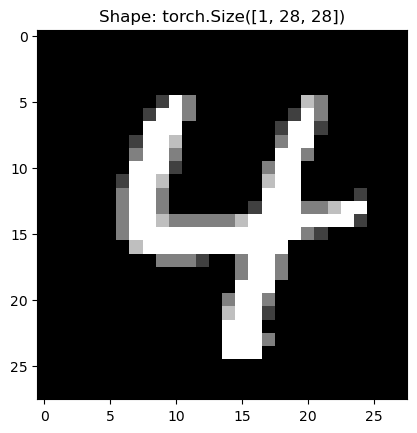

In [8]:
print(train_dataloader.__iter__().__next__()[0].shape)
plt.imshow(train_dataloader.__iter__().__next__()[0][0].cpu().numpy().squeeze(), cmap='gray')
plt.title(f"Shape: {train_dataloader.__iter__().__next__()[0][0].shape}")
plt.show()

In [9]:
model = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 64),
    down_block_types=("DownBlock2D",
                      "AttnDownBlock2D",
                      "AttnDownBlock2D",),
    up_block_types=("AttnUpBlock2D",
                    "AttnUpBlock2D",
                    "UpBlock2D",)
)
model.to(device)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

Finished epoch 0. Average loss for this epoch: 0.032001
Finished epoch 1. Average loss for this epoch: 0.023271
Finished epoch 2. Average loss for this epoch: 0.021656


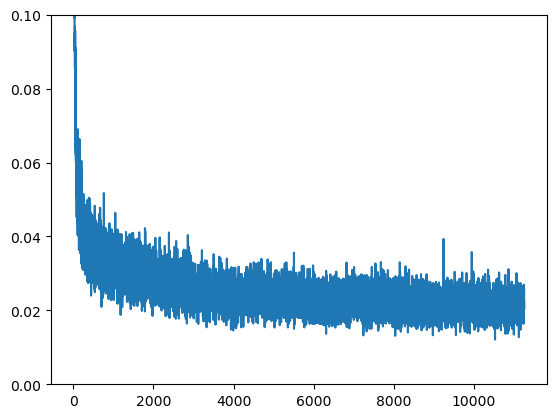

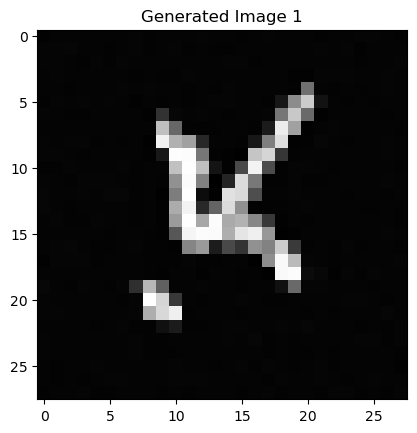

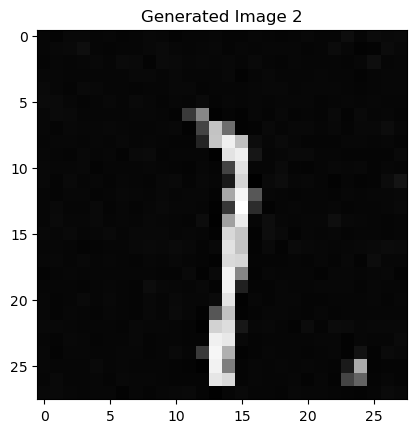

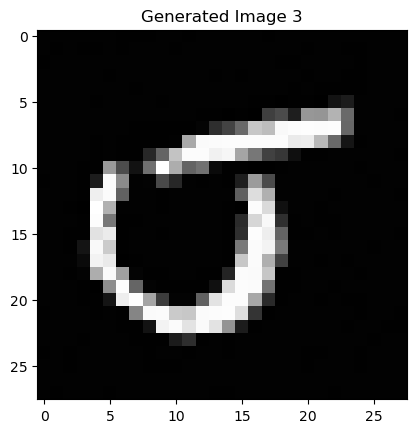

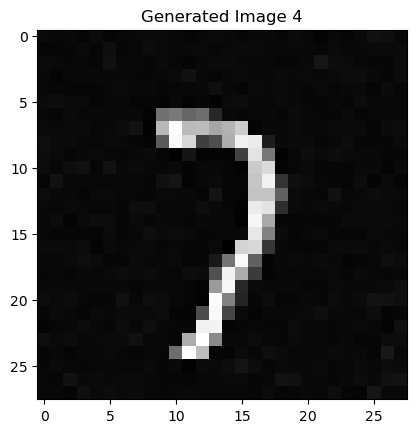

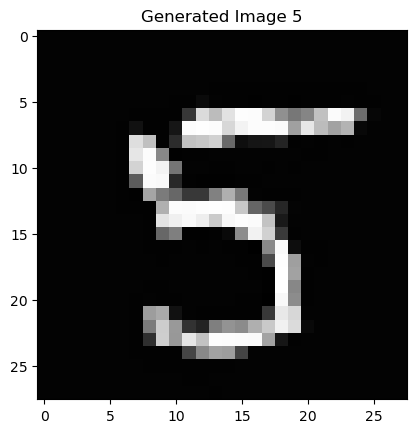

In [10]:
n_epochs = 3
for epoch in range(n_epochs):
    for x, y in train_dataloader:
        x = x.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.linspace(0, 999, batch_size).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        model_prediction = model(noisy_x, timesteps).sample
        loss = loss_fn(model_prediction, noise)

        # 反向传播，更新参数
        opt.zero_grad()
        loss.backward()
        opt.step()

        # 存储损失，供后期查看
        losses.append(loss.item())

    # 输出在每个周期训练得到的损失的均值
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

plt.plot(losses)
plt.ylim(0, 0.1)
# 生成图像
with torch.no_grad():
    for i in range(5):
        sample = torch.randn(1, 1, 28, 28).to(device)
        for t in reversed(range(1000)):
            timesteps = torch.tensor([t]).to(device)
            sample = noise_scheduler.step(model(sample, timesteps).sample, timesteps, sample).prev_sample

        plt.figure()
        plt.imshow(sample.cpu().numpy().squeeze(), cmap='gray')
        plt.title(f"Generated Image {i+1}")
        plt.show()